In [1]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [2]:
data = Dataset('results/din.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 controlNH4_mean,photic(time, node), float32 controlNO3_mean,photic(time, node), float32 c2936NH4_mean,photic(time, node), float32 c2936NO3_mean,photic(time, node), float32 q1c454NH4_mean,photic(time, node), float32 q1c454NO3_mean,photic(time, node), float32 q1c10NH4_mean,photic(time, node), float32 q1c10NO3_mean,photic(time, node), float32 q1c15NH4_mean,photic(time, node), float32 q1c15NO3_mean,photic(time, node), float32 q1c20NH4_mean,photic(time, node), float32 q1c20NO3_mean,photic(time, node), float32 q1c25NH4_mean,photic(time, node), float32 q1c25NO3_mean,photic(time, node), float32 q1c2936NH4_mean,photic(time, node), float32 q1c2936NO3_mean,photic(time, node), flo

In [5]:
def sort(vs):
    r = re.compile('q([1-9])c([0-9]+)')
    dec = []
    for v in vs:
        if v[-15:] != 'NH4_mean,photic':
            continue
        n = v[:-15] # Remove 'NH4_mean,photic'
        m = r.match(n)
        if m:
            q = m.group(1)
            c = m.group(2)
            if c == '454':
                c = '0' + c
        else:
            if n == 'control':
                q = '0'
                c = '0'
            else:
                q = '0'
                c = '1'
        dec.append((q, c, n))
    dec.sort()
    return [n for q, c, n in dec]

sort(data.variables)

['control',
 'c2936',
 'q1c454',
 'q1c10',
 'q1c15',
 'q1c20',
 'q1c25',
 'q1c2936',
 'q3c454',
 'q3c10',
 'q3c15',
 'q3c20',
 'q3c25',
 'q3c2936',
 'q5c454',
 'q5c10',
 'q5c15',
 'q5c20',
 'q5c25',
 'q5c2936',
 'q7c454',
 'q7c10',
 'q7c15',
 'q7c20',
 'q7c25',
 'q7c2936',
 'q9c454',
 'q9c10',
 'q9c15',
 'q9c20',
 'q9c25',
 'q9c2936']

In [6]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

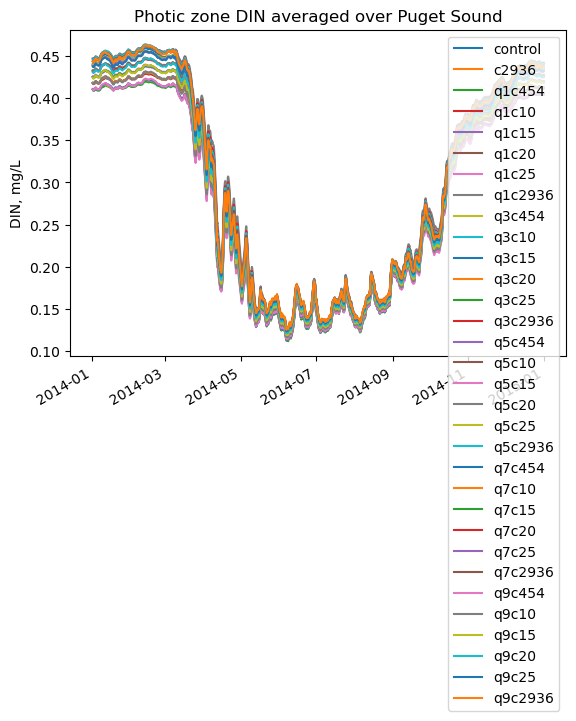

In [8]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')
fig, ax = plt.subplots()
din_avgs = {}
for name in sort(data.variables):
    ser = pd.Series(np.average(data[name + 'NH4_mean,photic'][:] + data[name + 'NO3_mean,photic'][:], axis=1, weights=areas), index=dates)
    ser.rolling('1D').mean().plot(ax=ax, label=name)
    din_avgs[name] = ser
din_avgs_df = pd.DataFrame(din_avgs)
ax.set(title='Photic zone DIN averaged over Puget Sound', ylabel='DIN, mg/L')
ax.legend()

In [9]:
din_avgs_df.to_excel('results/puget_sound/din_avg_mgl.xlsx')

In [10]:
sections_file = 'inlet_sections_aurora.ini'
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)

# names of sections that bound each control volume
cv_bounds = {
    'Penn Cove': ['PennCove'],
    'Holmes Harbor': ['HolmesHbr'],
    'Crescent Bay': ['CrescentBy'],
    'Carr Inlet': ['CarrInl'],
    'Case Inlet': ['CaseInl'],
    'Elliot Bay': ['ElliotBy'],
    'Commencement Bay': ['CommenceBy'],
    'Dabob Bay': ['DabobBy'],
    'Port Susan': ['PtSusan','StillaguamishSouthFork','StillaguamishPassSouth'],
    'Dyes Inlet': ['DyesInl'],
    'Sinclair Inlet': ['SinclairInl'],
    'Quartermaster Harbor': ['QtrHbr'],
    'Lynch Cove': ['LynchCove']
}

In [11]:
dirname = lambda n: n.lower().replace(' ', '_')

cvs = {}
for name, sectnames in cv_bounds.items():
    transects = []
    display(name)
    for sn in sectnames:
        waypoints = np.array(sections_config[sn]['waypoints'].split(' ')).astype(int)
        t = Transect.shortest(grid, waypoints)
        transects.append(t)
    cvs[name] = ControlVolume.from_transects(transects, calc=True)
    if not os.path.isdir(f'results/{dirname(name)}'):
        os.mkdir(f'results/{dirname(name)}')
    display(len(cvs[name].nodes))

'Penn Cove'

14

'Holmes Harbor'

26

'Crescent Bay'

10

'Carr Inlet'

157

'Case Inlet'

100

'Elliot Bay'

166

'Commencement Bay'

60

'Dabob Bay'

104

'Port Susan'

190

'Dyes Inlet'

42

'Sinclair Inlet'

16

'Quartermaster Harbor'

40

'Lynch Cove'

96

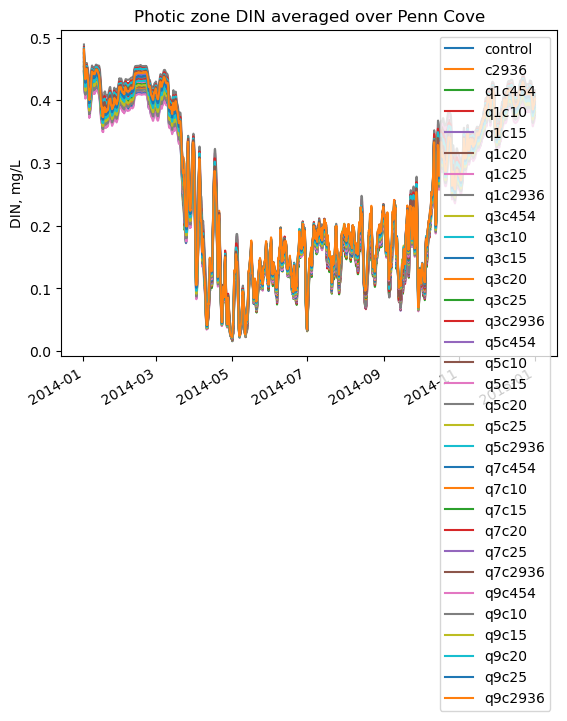

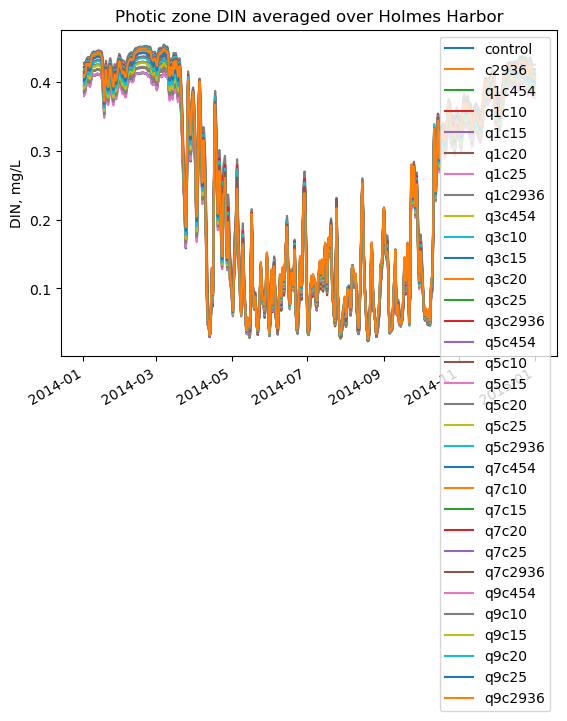

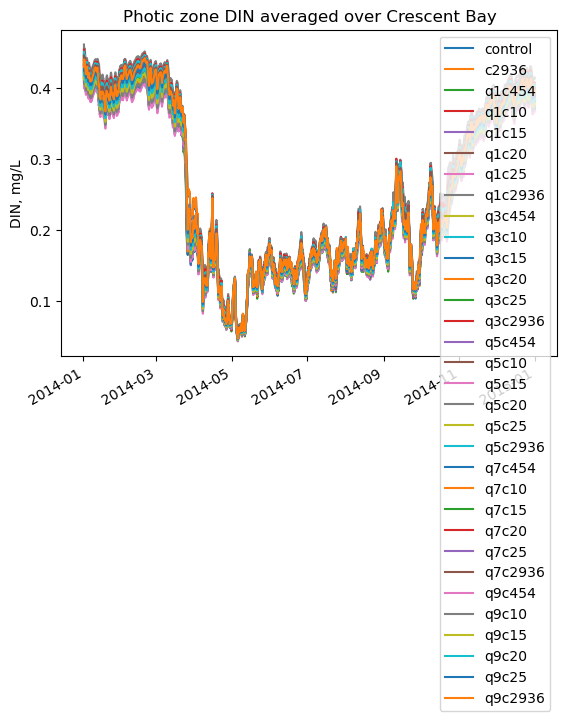

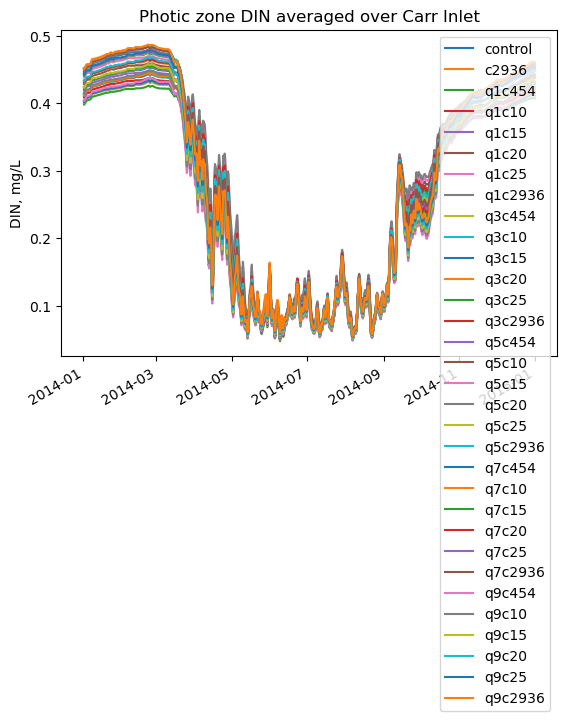

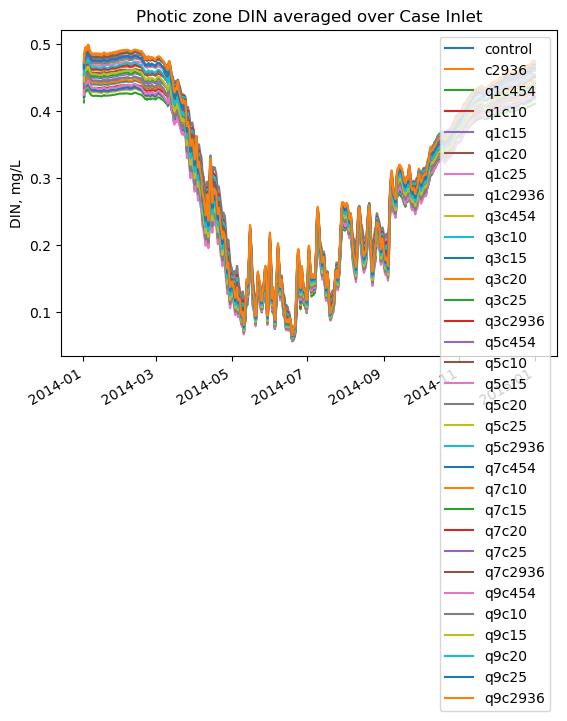

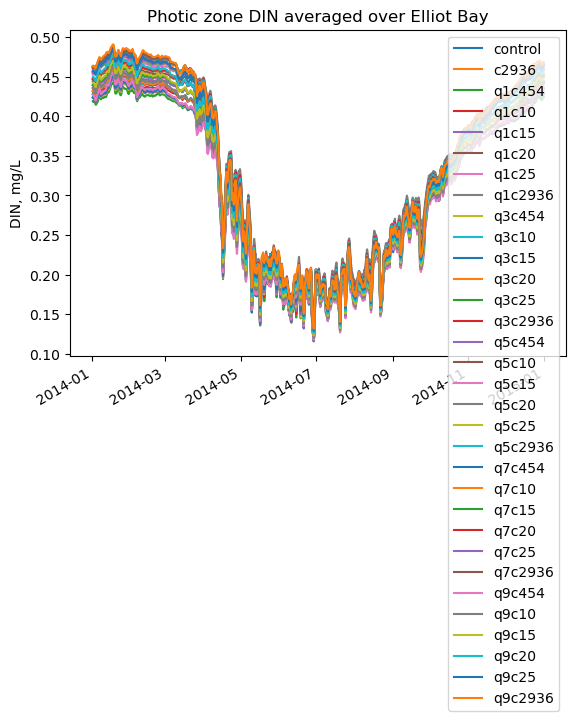

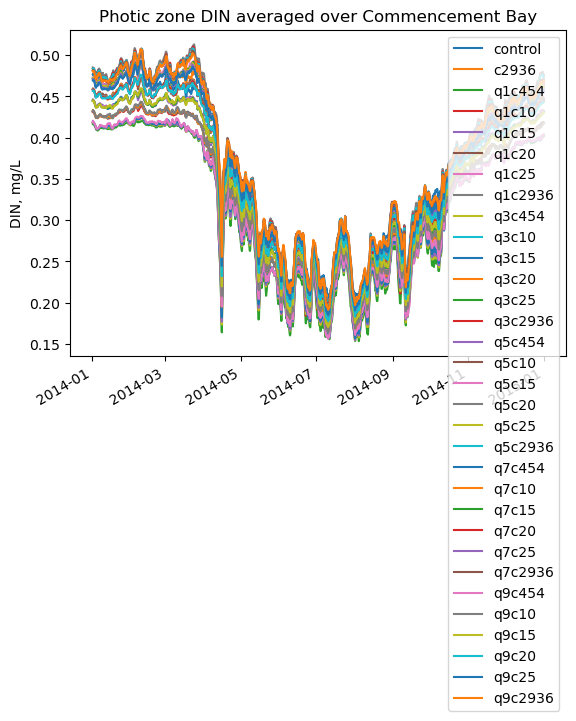

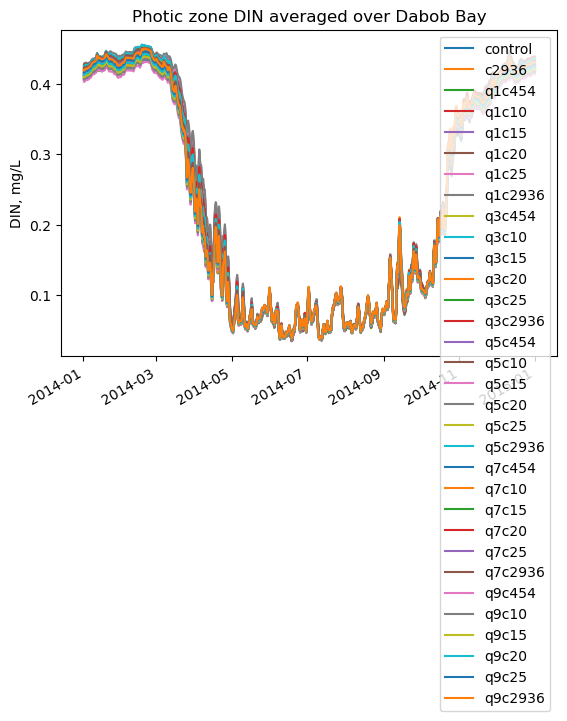

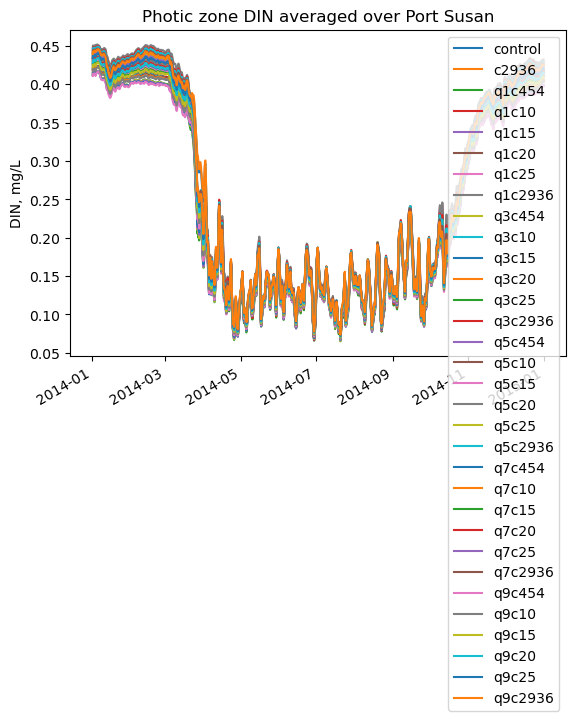

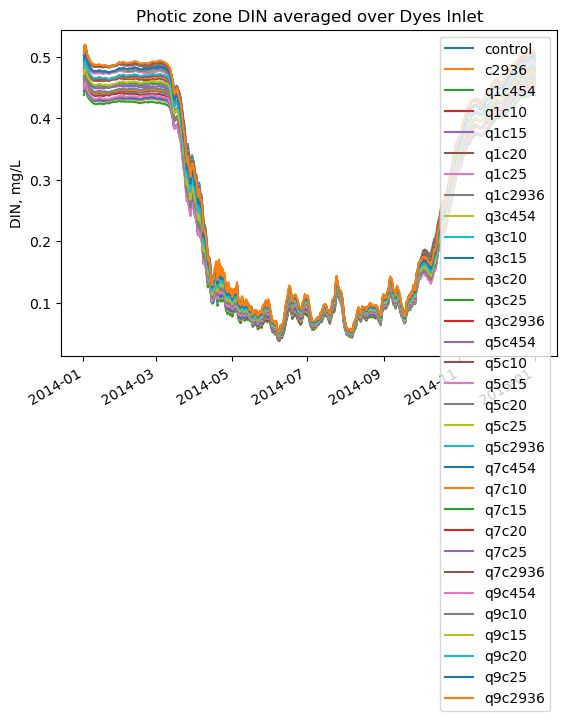

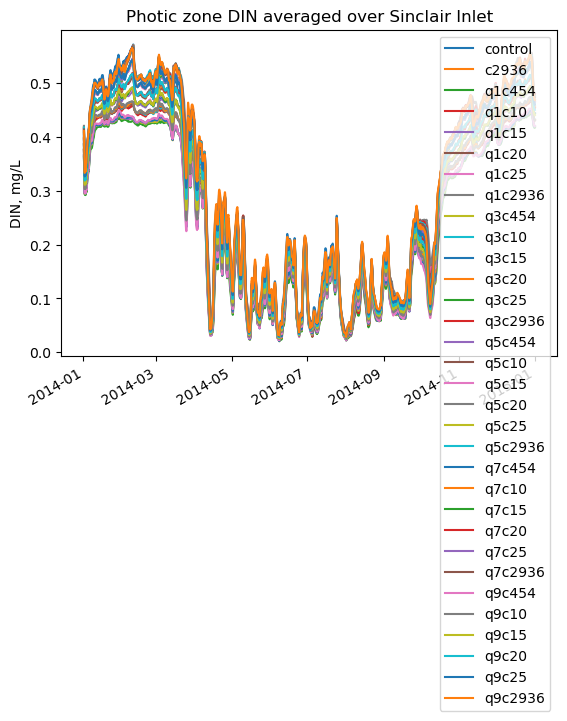

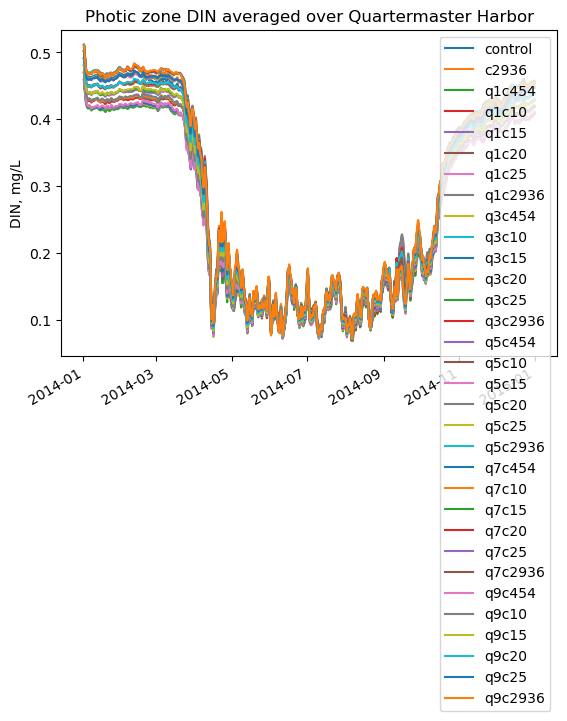

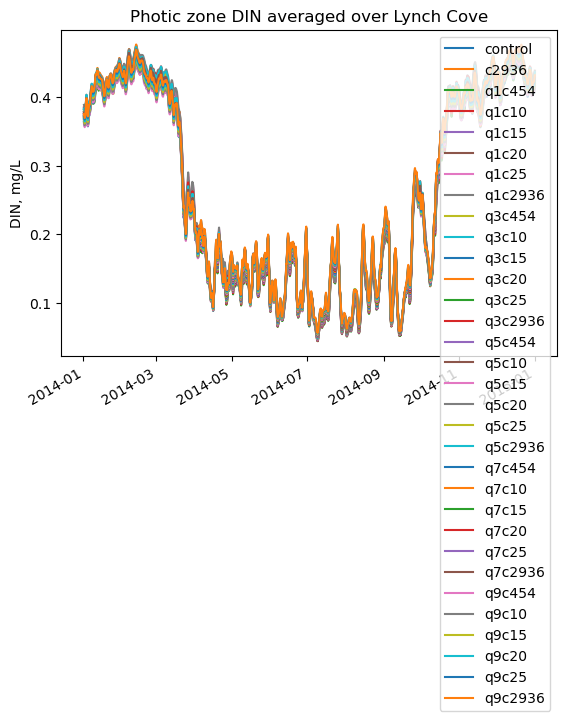

In [12]:
din_avgs_by_cv = {}
for cvname,cv in cvs.items():
    fig, ax = plt.subplots()
    din_avgs = {}
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for name in sort(data.variables):
        ser = pd.Series(np.average(data[name + 'NH4_mean,photic'][:,idxs] + data[name + 'NO3_mean,photic'][:,idxs], axis=1, weights=areas.iloc[idxs]), index=dates)
        ser.rolling('1D').mean().plot(ax=ax, label=name)
        din_avgs[name] = ser
    din_avgs_by_cv[cvname] = pd.DataFrame(din_avgs)
    ax.set(title=f'Photic zone DIN averaged over {cvname}', ylabel='DIN, mg/L')
    ax.legend()

In [13]:
for name,df in din_avgs_by_cv.items():
    display(name)
    display(df.mean())
    df.to_excel(f'results/{dirname(name)}/din_avg_mgl.xlsx')

'Penn Cove'

control    0.253806
c2936      0.255827
q1c454     0.238715
q1c10      0.243750
q1c15      0.248602
q1c20      0.253444
q1c25      0.258416
q1c2936    0.262729
q3c454     0.238040
q3c10      0.242704
q3c15      0.247242
q3c20      0.251713
q3c25      0.256371
q3c2936    0.260409
q5c454     0.237532
q5c10      0.242090
q5c15      0.246433
q5c20      0.250835
q5c25      0.255327
q5c2936    0.259295
q7c454     0.236745
q7c10      0.241065
q7c15      0.245251
q7c20      0.249540
q7c25      0.253825
q7c2936    0.257203
q9c454     0.235863
q9c10      0.240065
q9c15      0.244083
q9c20      0.248114
q9c25      0.252156
q9c2936    0.255743
dtype: float64

'Holmes Harbor'

control    0.248219
c2936      0.250045
q1c454     0.234428
q1c10      0.239189
q1c15      0.243608
q1c20      0.248008
q1c25      0.252518
q1c2936    0.256432
q3c454     0.233152
q3c10      0.237655
q3c15      0.241833
q3c20      0.246060
q3c25      0.250267
q3c2936    0.253985
q5c454     0.232571
q5c10      0.236965
q5c15      0.241073
q5c20      0.245188
q5c25      0.249321
q5c2936    0.252978
q7c454     0.231688
q7c10      0.235943
q7c15      0.239941
q7c20      0.243947
q7c25      0.247982
q7c2936    0.251136
q9c454     0.230733
q9c10      0.234772
q9c15      0.238596
q9c20      0.242489
q9c25      0.246394
q9c2936    0.249780
dtype: float64

'Crescent Bay'

control    0.254608
c2936      0.256559
q1c454     0.241541
q1c10      0.246636
q1c15      0.251424
q1c20      0.256200
q1c25      0.261140
q1c2936    0.265416
q3c454     0.239258
q3c10      0.243971
q3c15      0.248429
q3c20      0.252927
q3c25      0.257502
q3c2936    0.261497
q5c454     0.238111
q5c10      0.242626
q5c15      0.246955
q5c20      0.251400
q5c25      0.255852
q5c2936    0.259819
q7c454     0.236529
q7c10      0.240878
q7c15      0.245074
q7c20      0.249353
q7c25      0.253715
q7c2936    0.257066
q9c454     0.234533
q9c10      0.238714
q9c15      0.242638
q9c20      0.246650
q9c25      0.250840
q9c2936    0.254484
dtype: float64

'Carr Inlet'

control    0.276768
c2936      0.280756
q1c454     0.260902
q1c10      0.268126
q1c15      0.274856
q1c20      0.281592
q1c25      0.288365
q1c2936    0.294284
q3c454     0.257691
q3c10      0.264568
q3c15      0.271002
q3c20      0.277499
q3c25      0.284035
q3c2936    0.289748
q5c454     0.256083
q5c10      0.262836
q5c15      0.269181
q5c20      0.275575
q5c25      0.282029
q5c2936    0.287685
q7c454     0.254041
q7c10      0.260630
q7c15      0.266837
q7c20      0.273130
q7c25      0.279463
q7c2936    0.284340
q9c454     0.251070
q9c10      0.257475
q9c15      0.263475
q9c20      0.269594
q9c25      0.275769
q9c2936    0.281171
dtype: float64

'Case Inlet'

control    0.308057
c2936      0.315481
q1c454     0.280381
q1c10      0.288916
q1c15      0.296879
q1c20      0.304864
q1c25      0.312885
q1c2936    0.319890
q3c454     0.280990
q3c10      0.289164
q3c15      0.296824
q3c20      0.304556
q3c25      0.312337
q3c2936    0.319137
q5c454     0.280877
q5c10      0.288917
q5c15      0.296472
q5c20      0.304099
q5c25      0.311811
q5c2936    0.318560
q7c454     0.280160
q7c10      0.288025
q7c15      0.295448
q7c20      0.302952
q7c25      0.310514
q7c2936    0.316067
q9c454     0.279714
q9c10      0.287353
q9c15      0.294526
q9c20      0.301837
q9c25      0.309221
q9c2936    0.315675
dtype: float64

'Elliot Bay'

control    0.327896
c2936      0.331280
q1c454     0.304499
q1c10      0.311755
q1c15      0.318573
q1c20      0.325418
q1c25      0.332319
q1c2936    0.338349
q3c454     0.304022
q3c10      0.310984
q3c15      0.317551
q3c20      0.324175
q3c25      0.330861
q3c2936    0.336710
q5c454     0.303730
q5c10      0.310578
q5c15      0.317052
q5c20      0.323587
q5c25      0.330190
q5c2936    0.335985
q7c454     0.303040
q7c10      0.309755
q7c15      0.316117
q7c20      0.322553
q7c25      0.329049
q7c2936    0.334236
q9c454     0.302956
q9c10      0.309502
q9c15      0.315655
q9c20      0.321933
q9c25      0.328277
q9c2936    0.333845
dtype: float64

'Commencement Bay'

control    0.360403
c2936      0.363344
q1c454     0.308661
q1c10      0.321280
q1c15      0.333031
q1c20      0.344892
q1c25      0.356850
q1c2936    0.367291
q3c454     0.311270
q3c10      0.323295
q3c15      0.334526
q3c20      0.345902
q3c25      0.357366
q3c2936    0.367386
q5c454     0.312015
q5c10      0.323829
q5c15      0.334888
q5c20      0.346055
q5c25      0.357343
q5c2936    0.367230
q7c454     0.312711
q7c10      0.324277
q7c15      0.335103
q7c20      0.346074
q7c25      0.357134
q7c2936    0.366276
q9c454     0.314166
q9c10      0.325355
q9c15      0.335798
q9c20      0.346429
q9c25      0.357152
q9c2936    0.366526
dtype: float64

'Dabob Bay'

control    0.227609
c2936      0.228463
q1c454     0.226129
q1c10      0.228863
q1c15      0.231394
q1c20      0.233914
q1c25      0.236459
q1c2936    0.238685
q3c454     0.223954
q3c10      0.226452
q3c15      0.228821
q3c20      0.231187
q3c25      0.233555
q3c2936    0.235623
q5c454     0.222290
q5c10      0.224705
q5c15      0.226999
q5c20      0.229279
q5c25      0.231577
q5c2936    0.233597
q7c454     0.220169
q7c10      0.222499
q7c15      0.224707
q7c20      0.226912
q7c25      0.229129
q7c2936    0.230665
q9c454     0.218803
q9c10      0.220996
q9c15      0.223078
q9c20      0.225185
q9c25      0.227319
q9c2936    0.229158
dtype: float64

'Port Susan'

control    0.253337
c2936      0.255866
q1c454     0.235228
q1c10      0.240401
q1c15      0.245211
q1c20      0.250064
q1c25      0.255015
q1c2936    0.259334
q3c454     0.235121
q3c10      0.239950
q3c15      0.244474
q3c20      0.249053
q3c25      0.253705
q3c2936    0.257779
q5c454     0.234893
q5c10      0.239598
q5c15      0.244026
q5c20      0.248502
q5c25      0.253045
q5c2936    0.257043
q7c454     0.234354
q7c10      0.238934
q7c15      0.243226
q7c20      0.247524
q7c25      0.251934
q7c2936    0.255405
q9c454     0.233880
q9c10      0.238279
q9c15      0.242386
q9c20      0.246535
q9c25      0.250714
q9c2936    0.254417
dtype: float64

'Dyes Inlet'

control    0.262103
c2936      0.265032
q1c454     0.224513
q1c10      0.232550
q1c15      0.240046
q1c20      0.247566
q1c25      0.255166
q1c2936    0.261794
q3c454     0.227340
q3c10      0.235076
q3c15      0.242337
q3c20      0.249638
q3c25      0.256978
q3c2936    0.263378
q5c454     0.228190
q5c10      0.235808
q5c15      0.242996
q5c20      0.250224
q5c25      0.257492
q5c2936    0.263831
q7c454     0.228952
q7c10      0.236443
q7c15      0.243470
q7c20      0.250578
q7c25      0.257706
q7c2936    0.263570
q9c454     0.230670
q9c10      0.237984
q9c15      0.244836
q9c20      0.251785
q9c25      0.258767
q9c2936    0.264887
dtype: float64

'Sinclair Inlet'

control    0.296886
c2936      0.300006
q1c454     0.235656
q1c10      0.249112
q1c15      0.261720
q1c20      0.274438
q1c25      0.287261
q1c2936    0.298488
q3c454     0.238722
q3c10      0.251732
q3c15      0.263930
q3c20      0.276223
q3c25      0.288661
q3c2936    0.299480
q5c454     0.239447
q5c10      0.252281
q5c15      0.264363
q5c20      0.276507
q5c25      0.288780
q5c2936    0.299521
q7c454     0.240424
q7c10      0.253073
q7c15      0.264955
q7c20      0.276944
q7c25      0.289041
q7c2936    0.299219
q9c454     0.242015
q9c10      0.254401
q9c15      0.265963
q9c20      0.277715
q9c25      0.289549
q9c2936    0.299909
dtype: float64

'Quartermaster Harbor'

control    0.279566
c2936      0.283436
q1c454     0.252208
q1c10      0.259303
q1c15      0.266001
q1c20      0.272735
q1c25      0.279468
q1c2936    0.285397
q3c454     0.253286
q3c10      0.260106
q3c15      0.266604
q3c20      0.273217
q3c25      0.279814
q3c2936    0.285543
q5c454     0.253658
q5c10      0.260460
q5c15      0.266866
q5c20      0.273385
q5c25      0.279886
q5c2936    0.285546
q7c454     0.253633
q7c10      0.260354
q7c15      0.266635
q7c20      0.273045
q7c25      0.279391
q7c2936    0.284506
q9c454     0.254160
q9c10      0.260753
q9c15      0.266834
q9c20      0.273043
q9c25      0.279224
q9c2936    0.284617
dtype: float64

'Lynch Cove'

control    0.262956
c2936      0.263789
q1c454     0.250568
q1c10      0.253439
q1c15      0.256089
q1c20      0.258686
q1c25      0.261278
q1c2936    0.263531
q3c454     0.252250
q3c10      0.254875
q3c15      0.257354
q3c20      0.259803
q3c25      0.262271
q3c2936    0.264419
q5c454     0.252928
q5c10      0.255509
q5c15      0.257906
q5c20      0.260336
q5c25      0.262762
q5c2936    0.264861
q7c454     0.252455
q7c10      0.254947
q7c15      0.257303
q7c20      0.259625
q7c25      0.261980
q7c2936    0.263552
q9c454     0.253659
q9c10      0.256027
q9c15      0.258281
q9c20      0.260528
q9c25      0.262780
q9c2936    0.264748
dtype: float64